In [1]:
!python3 -m pip install --force-reinstall --no-cache boto3
!python3 -m pip install --force-reinstall --no-cache pyautogui
!python3 -m pip install --force-reinstall --no-cache pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 32.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.3.0
    Uninstalling urllib3-2.3.0:
      Successfully uninstalled urllib3-2.3.0
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled six-1.17.0
  Attempting uninstall: jmespath
    Found existing installation: jmespath 1.0.1
    Uninstalling jmespath-1.0.1:
      Successfully uninstalled jmespath-1.0.1
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.9.0.post0
    Uninstalling python-dateutil-2.9.0.post0:
      Successfully uninstalled python-dateutil-2.9.0.post0
  Attempting uninstall: botocore
    Found existing installation: botocore 1.35.86
    Uninstalling botocore-1.35.86:
      Successfully uninstalled botocore-1.35.86
  Attempting uninstall: s3transfer
    Found existing installation: s3transfer 0.

In [2]:
import logging
import boto3
import time
import zipfile
from io import BytesIO
import json
import uuid
import pprint
import platform
from PIL import Image

# setting logger
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

from botocore.config import Config

boto3_config = Config(
    region_name = 'us-east-1',
    signature_version = 'v4',
    retries = {
        'max_attempts': 10,
        'mode': 'standard'
    }
)

session = boto3.Session(profile_name='ml-sandbox')

bedrock_agent_client = session.client('bedrock-agent', config=boto3_config)
bedrock_agent_runtime_client = session.client('bedrock-agent-runtime', config=boto3_config)
bedrock_runtime_client = session.client("bedrock-runtime", config=boto3_config)

[2024-12-23 21:32:37,100] p11073 {credentials.py:1278} INFO - Found credentials in shared credentials file: ~/.aws/credentials


In [3]:
from IPython.display import Image 
from PIL import Image, ImageDraw

def get_tool_use(content):
    for item in content:
        if 'toolUse' in item:
            yield item['toolUse']

def click_on_screenshot(screenshot, x,y):
    with Image.open(screenshot) as im:
        draw = ImageDraw.Draw(im)
        draw.circle((x,y), 50, fill='red')
        display(im)
    # with Image.open('test_images/initial_screen.png') as im:
    #     draw = ImageDraw.Draw(im)
    #     draw.circle((423,433), 50, fill='red')
    #     display(im)
    # pil_img = Image(filename='test_images/initial_screen.png')
    # display(pil_img)                

In [4]:
system_content=[{'text': f"""You are a helpful AI agent with access to computer control.
                Always think step by step.
                ENVIRONMENT:
                1. {platform.system()}                 
            """
}]
additionalModelRequestFields_content={
            "tools": [
                {
                    "type": "computer_20241022",
                    "name": "computer",
                    "display_height_px": 1856,
                    "display_width_px": 1332,
                    "display_number": 0
                }
            ],
            "anthropic_beta": ["computer-use-2024-10-22"]
        }
toolConfig_conent={
    'tools': [
        {
            'toolSpec': {
                'name': 'computer_tool',
                'inputSchema': {
                    'json': {
                        'type': 'object'
                    }
                }
            }
        }
    ]
}

In [5]:
import pyautogui
from time import sleep

def send_bedrock(messages):
    response = bedrock_runtime_client.converse(
        modelId='us.anthropic.claude-3-5-sonnet-20241022-v2:0',
        messages=messages,
        system=system_content,        
        toolConfig=toolConfig_conent,
        additionalModelRequestFields=additionalModelRequestFields_content       
        )
    return response


In [6]:
def handle_action(response, input_screenshot=None, output_screenshot=None):
    stopReason = response['stopReason']

    match stopReason:
        case 'end_turn':
            logger.debug(f"end_turn")
            return
        case 'tool_use':
            message = response['output']['message']

            user_toolResult_contents=[]            

            for toolUse in get_tool_use(message['content']):
                text = message['content'][0].get('text')
                input_data = toolUse['input']
                action = input_data.get('action')
                # logger.info(f"toolUse: {toolUse}, input_data: {input_data}, action: {action}")

                match action:
                    case 'screenshot':
                        logger.debug(f"screenshot")
                    #     screenshot = get_screenshot()
                    #     print(screenshot)
                    case 'type':
                        text = input_data.get('text')
                        logger.debug(f"type:{text}")
                    case 'key':
                        key = input_data.get('text')
                        logger.debug(f"key:{key}")
                    case 'left_click':
                        logger.debug(f"left_click")
                        with Image.open(input_screenshot) as im:
                            display(im)
                        # pyautogui.click()
                        # sleep(0.25)
                        # screenshot = get_screenshot()
                    case 'mouse_move':
                        coordinate = input_data['coordinate']
                        logger.info(f"coordinate: {coordinate}")
                        if coordinate:
                            x, y = tuple(input_data['coordinate'])
                            click_on_screenshot(input_screenshot, x, y)
                            sleep(0.25)
                    case _:
                        print("Unsupported action received")
                        break

                tool_use_id = toolUse['toolUseId']
            #     # assistant_toolResult_response=message['content']
                response={
                    'toolResult': {
                        'toolUseId': tool_use_id,
                        'content':[
                            {
                                'text': 'OK'
                            }
                        ]
                    }
                }
                if(output_screenshot):
                    with open(output_screenshot, "rb") as image:
                        f = image.read()
                        image_bytearray = bytearray(f)

                    response['toolResult']['content'].append({
                        'image': {
                            'format': 'png',    
                            'source': {
                                'bytes': image_bytearray
                            }
                        }
                    })
                    
                user_toolResult_contents.append(response)
                return user_toolResult_contents
            
        case _:
            logger.debug(f"Unsupported stop reason: {stopReason}")
            return


## Initial request

In [7]:
with open('test_images/1-initial_screen.png', "rb") as image:
  f = image.read()
  first_image = bytearray(f)

message1 = [{
    'role': 'user',
    'content': [
        {
            'text': 'Go to the bedrock console'
        },
        {
            'image': {
                'format': 'png',
                'source': {
                    'bytes': first_image
                }
            }
        }
    ]
}]

agent_action1=send_bedrock(message1)
# logger.info(f"response:{agent_action1}")
pprint.pprint(agent_action1)


{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '478',
                                      'content-type': 'application/json',
                                      'date': 'Mon, 23 Dec 2024 13:32:46 GMT',
                                      'x-amzn-requestid': '76280f72-72d8-4c9b-be7b-bc9e60e38ec6'},
                      'HTTPStatusCode': 200,
                      'RequestId': '76280f72-72d8-4c9b-be7b-bc9e60e38ec6',
                      'RetryAttempts': 0},
 'metrics': {'latencyMs': 4984},
 'output': {'message': {'content': [{'text': "I'll help you navigate to the "
                                             'AWS Bedrock console. Let me do '
                                             'this step by step:\n'
                                             '\n'
                                             "1. First, I'll click on the "
                                             'search bar and type the AW

[2024-12-23 21:32:46,321] p11073 {287690401.py:39} INFO - coordinate: [260, 493]


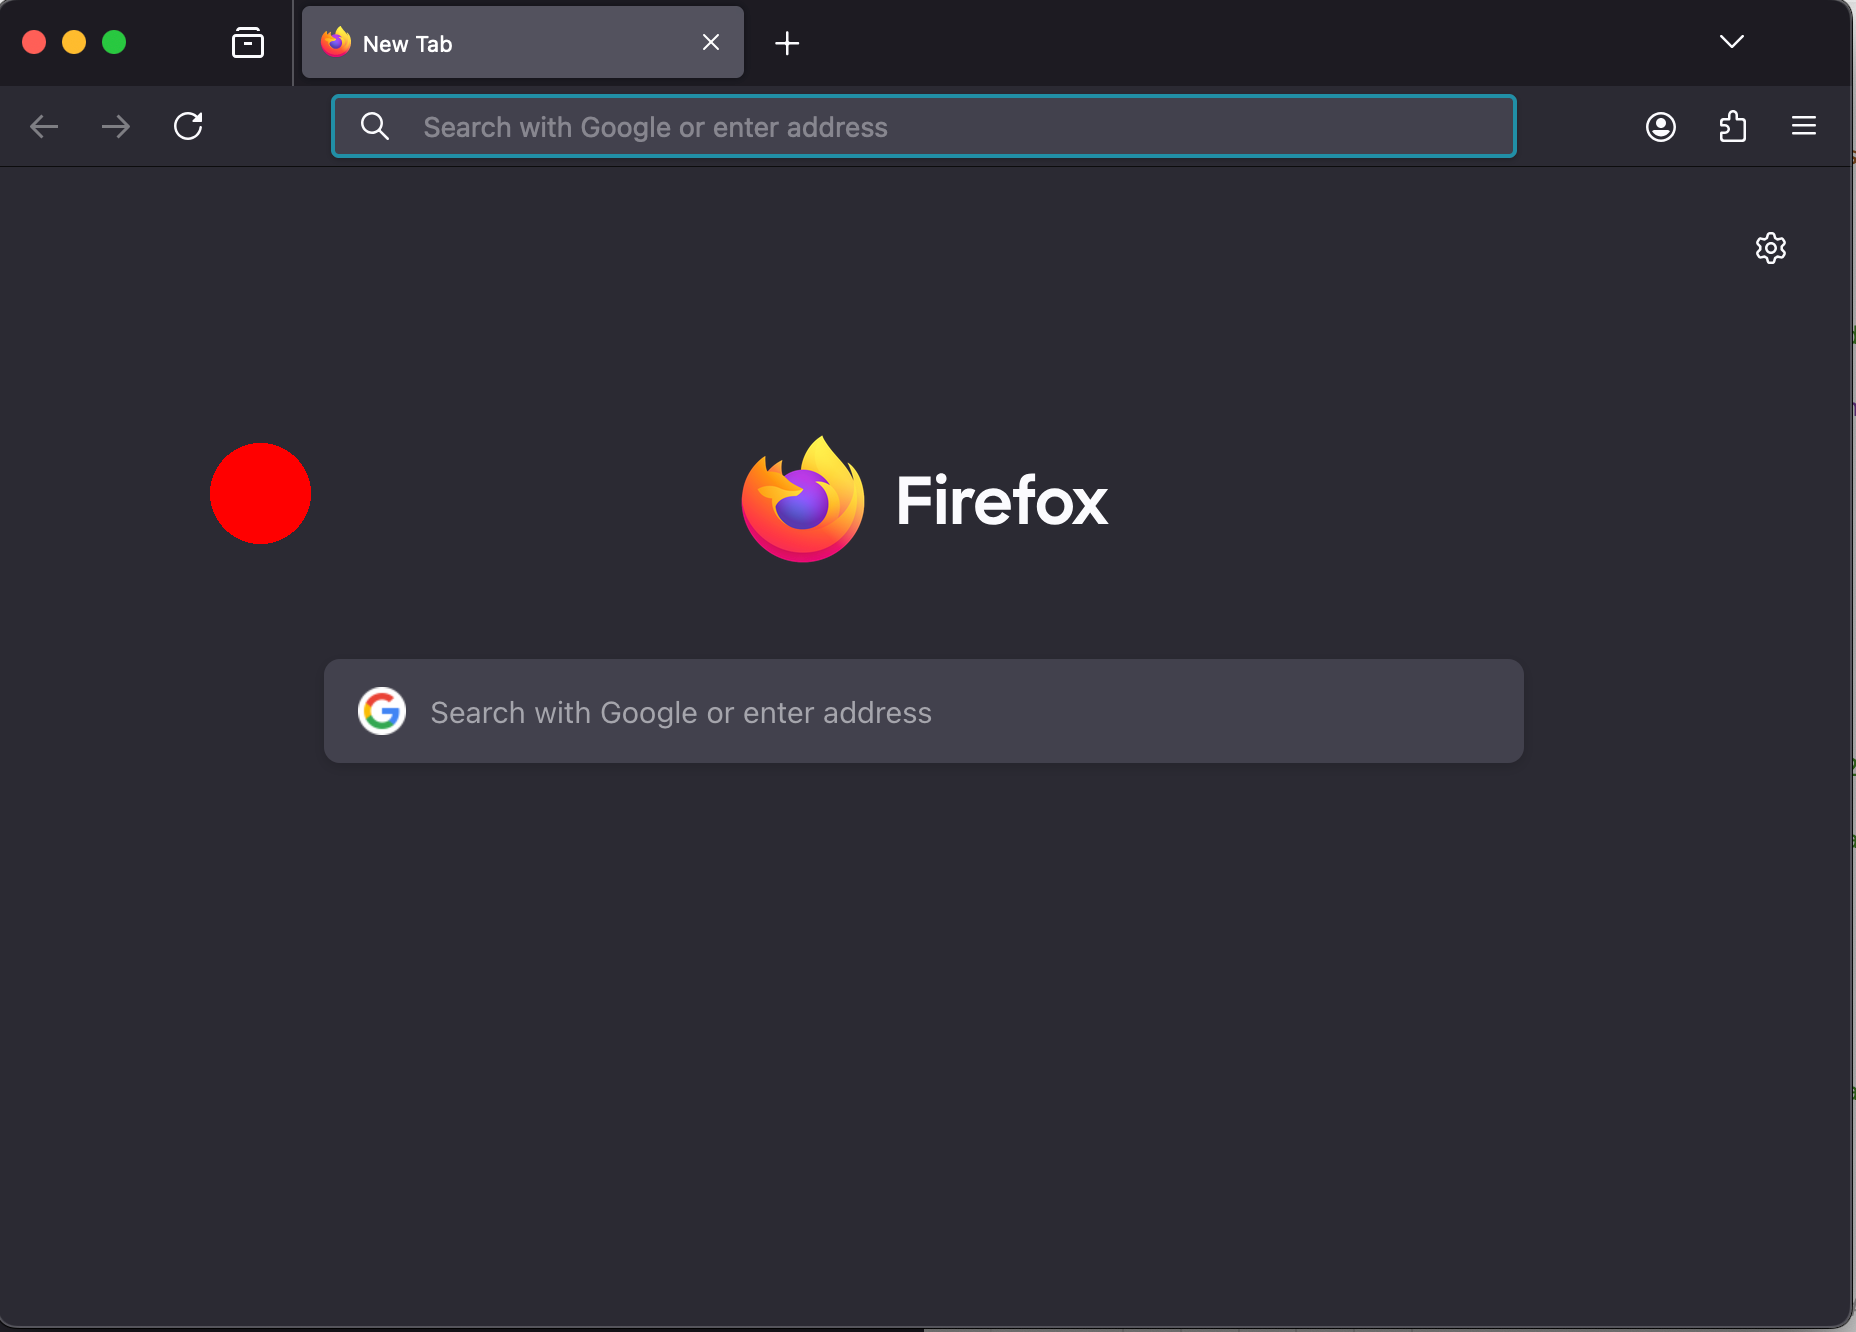

In [8]:
user_toolResult1=handle_action(agent_action1,
    input_screenshot='test_images/1-initial_screen.png',
    output_screenshot='test_images/2-firefox_address_bar.png'
)
# logger.info(f"response:{user_toolResult1}")
# pprint.pprint(user_toolResult1)


## Second request

In [9]:
message2 = message1 + [{
        'role':'assistant',
        'content': agent_action1['output']['message']['content']
    },
    {
        'role':'user',
        'content': user_toolResult1
    },
]

agent_action2=send_bedrock(message2)
# logger.info(f"response:{agent_action2}")
pprint.pprint(agent_action2)

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '283',
                                      'content-type': 'application/json',
                                      'date': 'Mon, 23 Dec 2024 13:32:51 GMT',
                                      'x-amzn-requestid': '0f66793c-9dd5-4487-baf4-76fcae8131f2'},
                      'HTTPStatusCode': 200,
                      'RequestId': '0f66793c-9dd5-4487-baf4-76fcae8131f2',
                      'RetryAttempts': 0},
 'metrics': {'latencyMs': 3672},
 'output': {'message': {'content': [{'toolUse': {'input': {'action': 'left_click'},
                                                 'name': 'computer',
                                                 'toolUseId': 'tooluse_RWjOEFvmTjGlM6XTkr0ZFg'}}],
                        'role': 'assistant'}},
 'stopReason': 'tool_use',
 'usage': {'inputTokens': 4448, 'outputTokens': 54, 'totalTokens': 4502}}


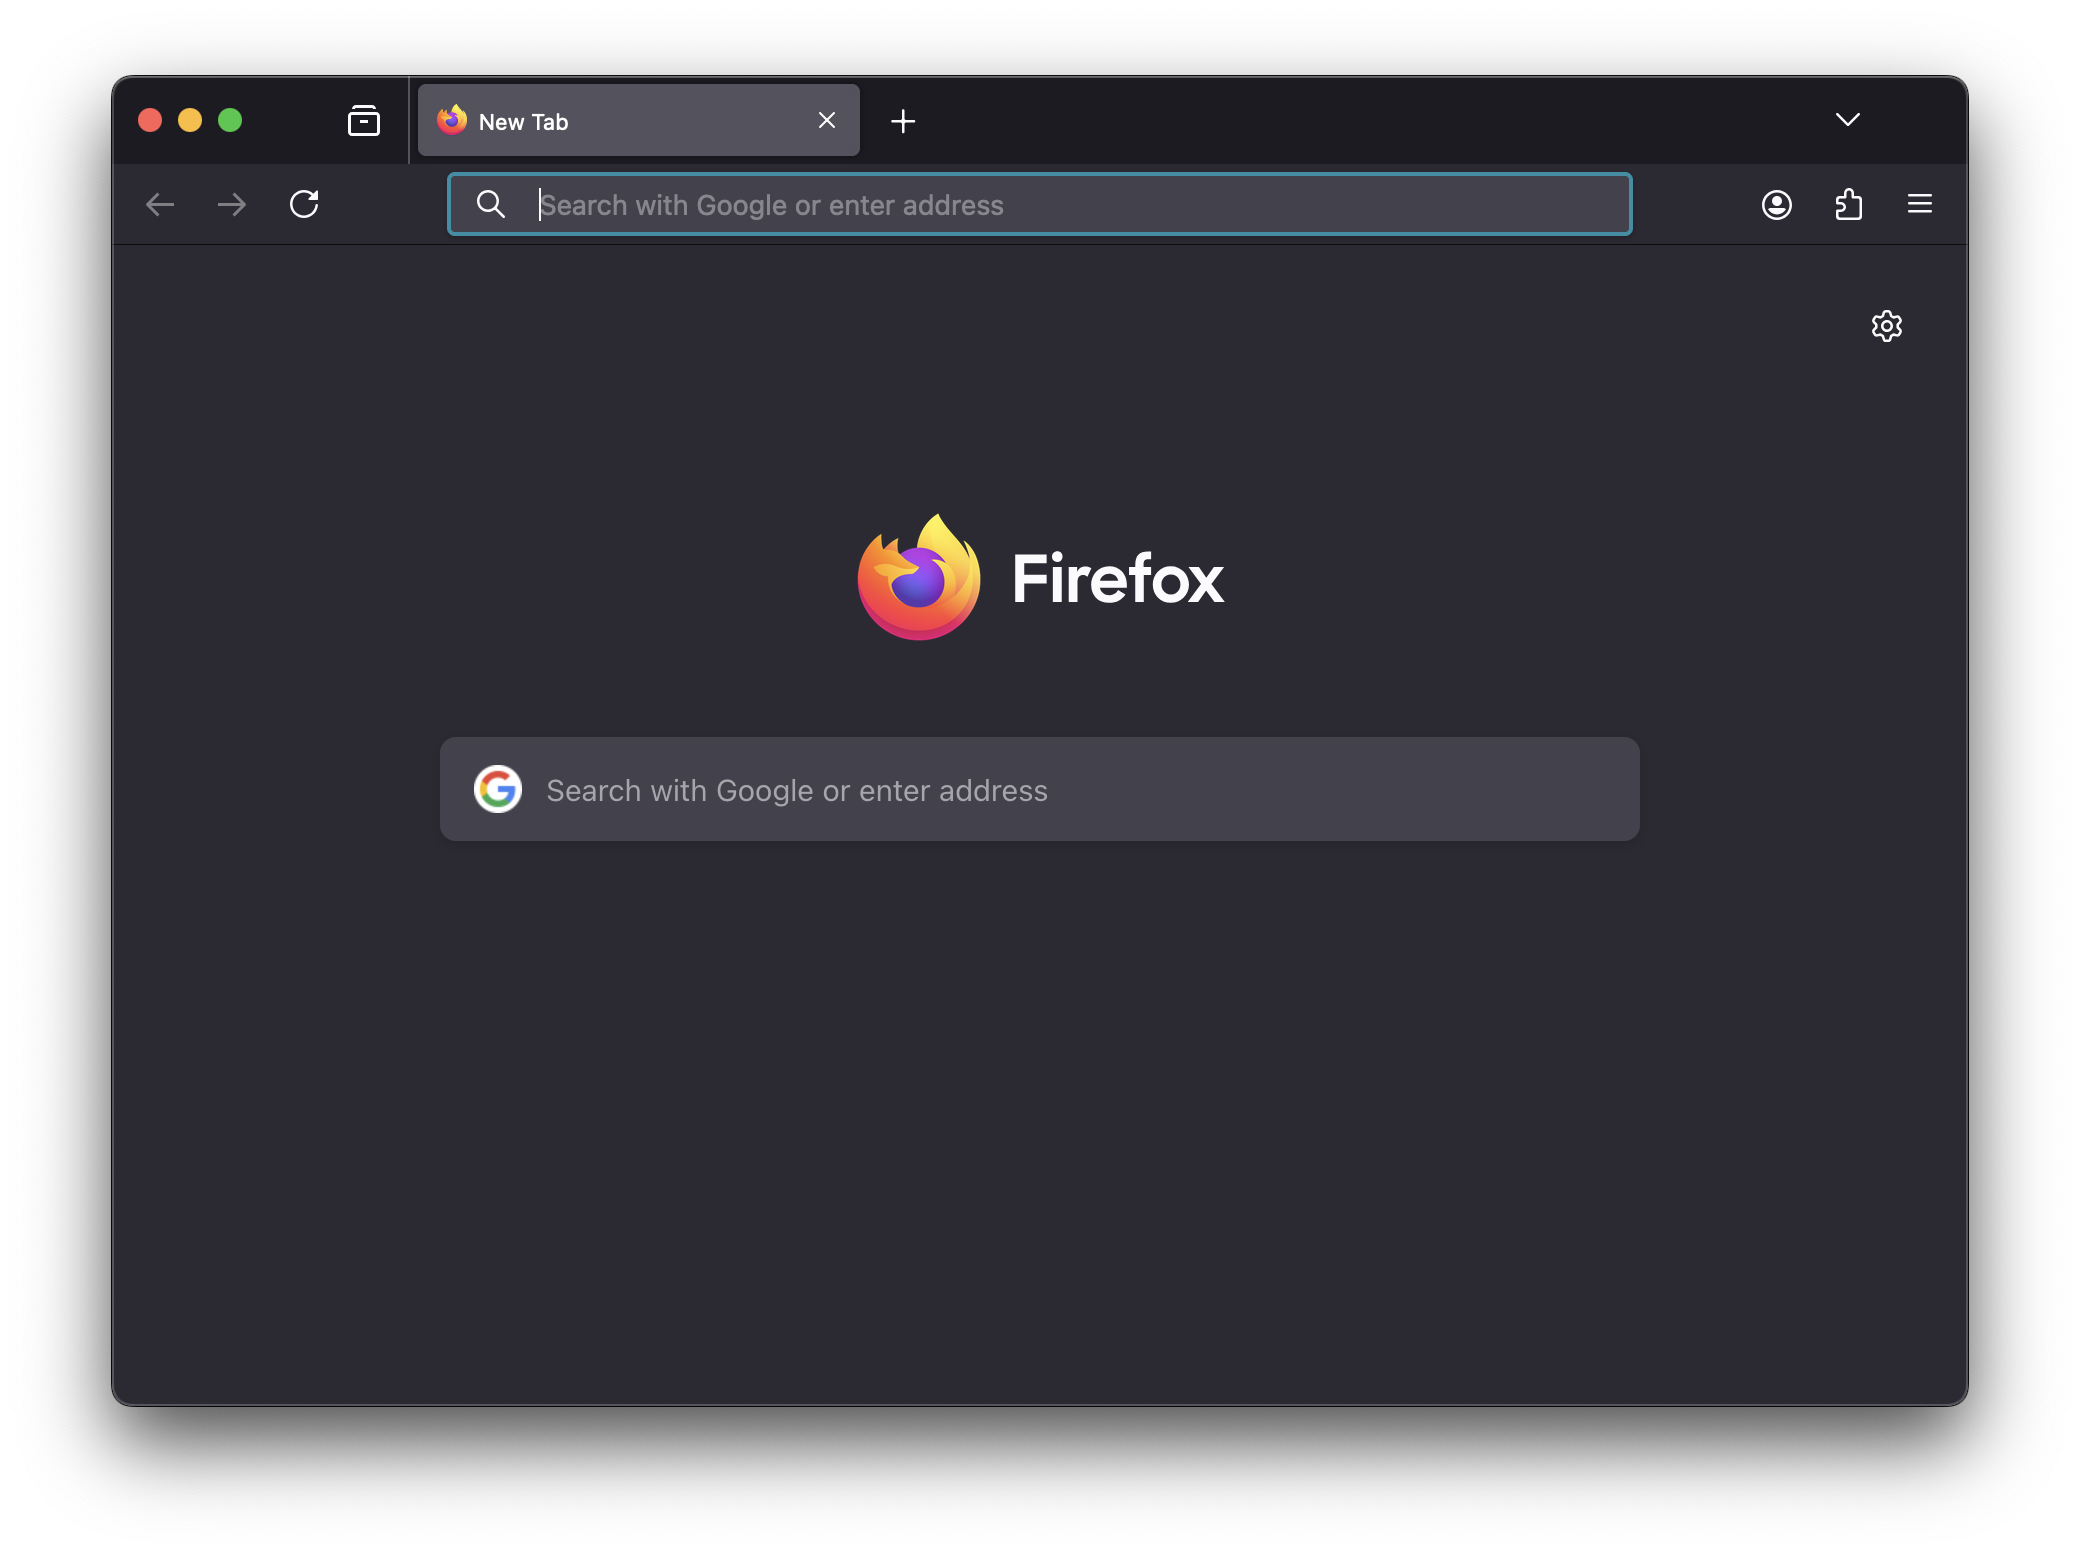

In [10]:
user_toolResult2=handle_action(agent_action2,
    input_screenshot='test_images/2-firefox_address_bar.png'
)


## Third request

In [11]:
message3 = message2 + [{
        'role':'assistant',
        'content': agent_action2['output']['message']['content']
    },
    {
        'role':'user',
        'content': user_toolResult2
    },
]

agent_action3=send_bedrock(message3)
# logger.info(f"response:{agent_action3}")
pprint.pprint(agent_action3)

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '340',
                                      'content-type': 'application/json',
                                      'date': 'Mon, 23 Dec 2024 13:33:23 GMT',
                                      'x-amzn-requestid': 'ff8ab8af-9b7b-4704-97bf-a3ac2442356b'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'ff8ab8af-9b7b-4704-97bf-a3ac2442356b',
                      'RetryAttempts': 7},
 'metrics': {'latencyMs': 3410},
 'output': {'message': {'content': [{'toolUse': {'input': {'action': 'type',
                                                           'text': 'https://us-east-1.console.aws.amazon.com/bedrock/home'},
                                                 'name': 'computer',
                                                 'toolUseId': 'tooluse_T1sEuaShRe6WVrEBbrkGdQ'}}],
                        'role': 'assistant'}},
 'stop

In [12]:
user_toolResult3=handle_action(agent_action3,
    input_screenshot='test_images/2-firefox_address_bar.png',
    output_screenshot='test_images/3-firefox_address_bar_text.png'
)

## Forth request

In [13]:
message4 = message3 + [{
        'role':'assistant',
        'content': agent_action3['output']['message']['content']
    },
    {
        'role':'user',
        'content': user_toolResult3
    },
]

agent_action4=send_bedrock(message4)
# logger.info(f"response:{agent_action4}")
pprint.pprint(agent_action4)

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '292',
                                      'content-type': 'application/json',
                                      'date': 'Mon, 23 Dec 2024 13:33:49 GMT',
                                      'x-amzn-requestid': '8f876b01-d46d-494e-87cc-2d9c35debd14'},
                      'HTTPStatusCode': 200,
                      'RequestId': '8f876b01-d46d-494e-87cc-2d9c35debd14',
                      'RetryAttempts': 6},
 'metrics': {'latencyMs': 3954},
 'output': {'message': {'content': [{'toolUse': {'input': {'action': 'key',
                                                           'text': 'Return'},
                                                 'name': 'computer',
                                                 'toolUseId': 'tooluse_pq1vPRhsScmiHOZzgH8yAw'}}],
                        'role': 'assistant'}},
 'stopReason': 'tool_use',
 'usage': {'inputTokens': 6

In [14]:
user_toolResult4=handle_action(agent_action4,
    input_screenshot='test_images/3-firefox_address_bar_text.png',
    output_screenshot='test_images/4-firefox_address_bar_text_enter.png'
)

## 5th request

In [15]:
message5 = message4 + [{
        'role':'assistant',
        'content': agent_action4['output']['message']['content']
    },
    {
        'role':'user',
        'content': user_toolResult4
    },
]

agent_action5=send_bedrock(message5)
# logger.info(f"response:{agent_action5}")
pprint.pprint(agent_action5)

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '662',
                                      'content-type': 'application/json',
                                      'date': 'Mon, 23 Dec 2024 13:34:37 GMT',
                                      'x-amzn-requestid': '320457c4-9e13-4fe9-93e2-39dd4a005589'},
                      'HTTPStatusCode': 200,
                      'RequestId': '320457c4-9e13-4fe9-93e2-39dd4a005589',
                      'RetryAttempts': 7},
 'metrics': {'latencyMs': 6763},
 'output': {'message': {'content': [{'text': "I see we've been redirected to "
                                             'the AWS sign-in page. To access '
                                             "the Bedrock console, you'll need "
                                             'to sign in with your AWS account '
                                             'credentials. Could you please '
                        

## 6th request

In [16]:
# user_toolResult5=handle_action(agent_action5,
#     input_screenshot='test_images/4-firefox_address_bar_text_enter.png',
#     output_screenshot='test_images/4-firefox_address_bar_text_enter.png'
# )

message6 = message5 + [{
        'role':'assistant',
        'content': agent_action5['output']['message']['content']
    },
    {
        'role':'user',
        'content': [
            {'text': 'richard@doit.com'}
        ]
    }
]
agent_action6=send_bedrock(message6)
pprint.pprint(agent_action6)

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '560',
                                      'content-type': 'application/json',
                                      'date': 'Mon, 23 Dec 2024 13:35:10 GMT',
                                      'x-amzn-requestid': '07fcedc4-b4c6-4e61-b969-afc520e604ee'},
                      'HTTPStatusCode': 200,
                      'RequestId': '07fcedc4-b4c6-4e61-b969-afc520e604ee',
                      'RetryAttempts': 6},
 'metrics': {'latencyMs': 6453},
 'output': {'message': {'content': [{'text': "I'll help you enter the email "
                                             'address and proceed with the '
                                             'sign-in process.\n'
                                             '\n'
                                             '1. First, I see that "Root user" '
                                             'is already selected by de

[2024-12-23 21:35:10,692] p11073 {287690401.py:39} INFO - coordinate: [306, 779]


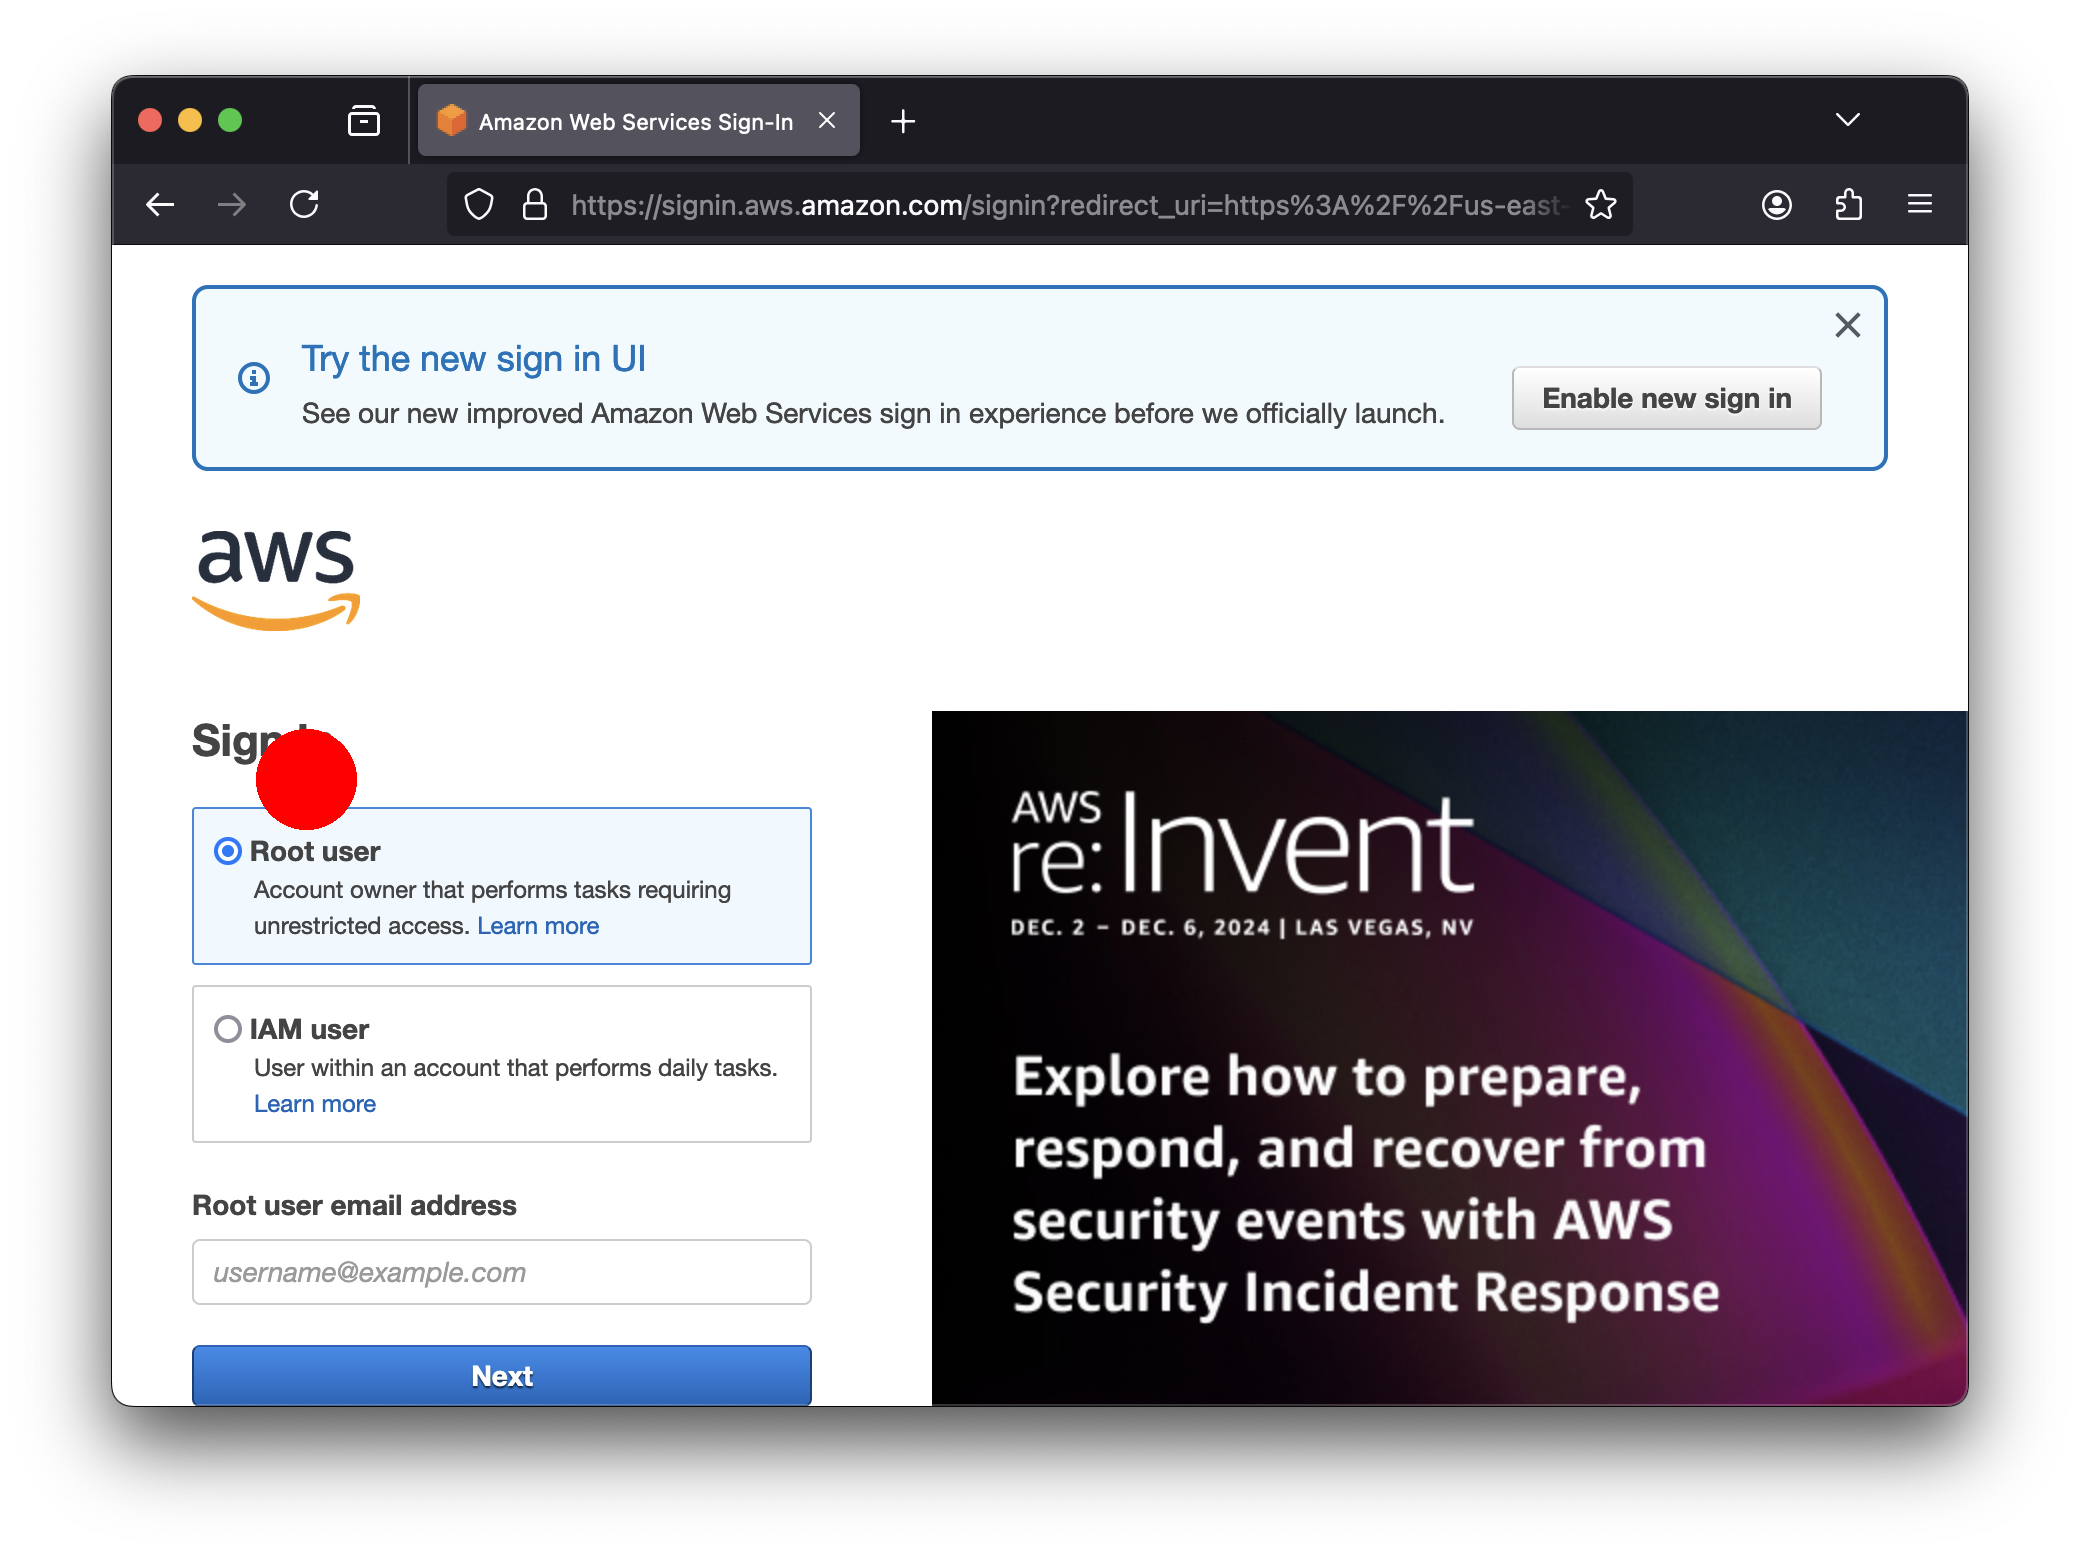

In [17]:
user_toolResult6=handle_action(agent_action6,
    input_screenshot='test_images/4-firefox_address_bar_text_enter.png',
    output_screenshot='test_images/5-firefox_aws_console.png'
)

## 7th request

In [19]:
# user_toolResult5=handle_action(agent_action5,
#     input_screenshot='test_images/4-firefox_address_bar_text_enter.png',
#     output_screenshot='test_images/4-firefox_address_bar_text_enter.png'
# )

message7 = message6 + [{
        'role':'assistant',
        'content': agent_action6['output']['message']['content']
    },
    {
        'role':'user',
        'content': user_toolResult6
    }
]
agent_action7=send_bedrock(message7)
# logger.info(f"response:{agent_action7}")
pprint.pprint(agent_action7)

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '498',
                                      'content-type': 'application/json',
                                      'date': 'Mon, 23 Dec 2024 13:40:05 GMT',
                                      'x-amzn-requestid': 'e237a1f5-93b1-476a-9839-aa4f9298c9f3'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'e237a1f5-93b1-476a-9839-aa4f9298c9f3',
                      'RetryAttempts': 0},
 'metrics': {'latencyMs': 6918},
 'output': {'message': {'content': [{'text': "I see you're already signed in "
                                             'to the AWS Console! And I can '
                                             'see Amazon Bedrock is listed in '
                                             'your recently visited services. '
                                             'Let me click on it to take you '
                           

[2024-12-23 21:40:09,853] p11073 {287690401.py:39} INFO - coordinate: [218, 449]


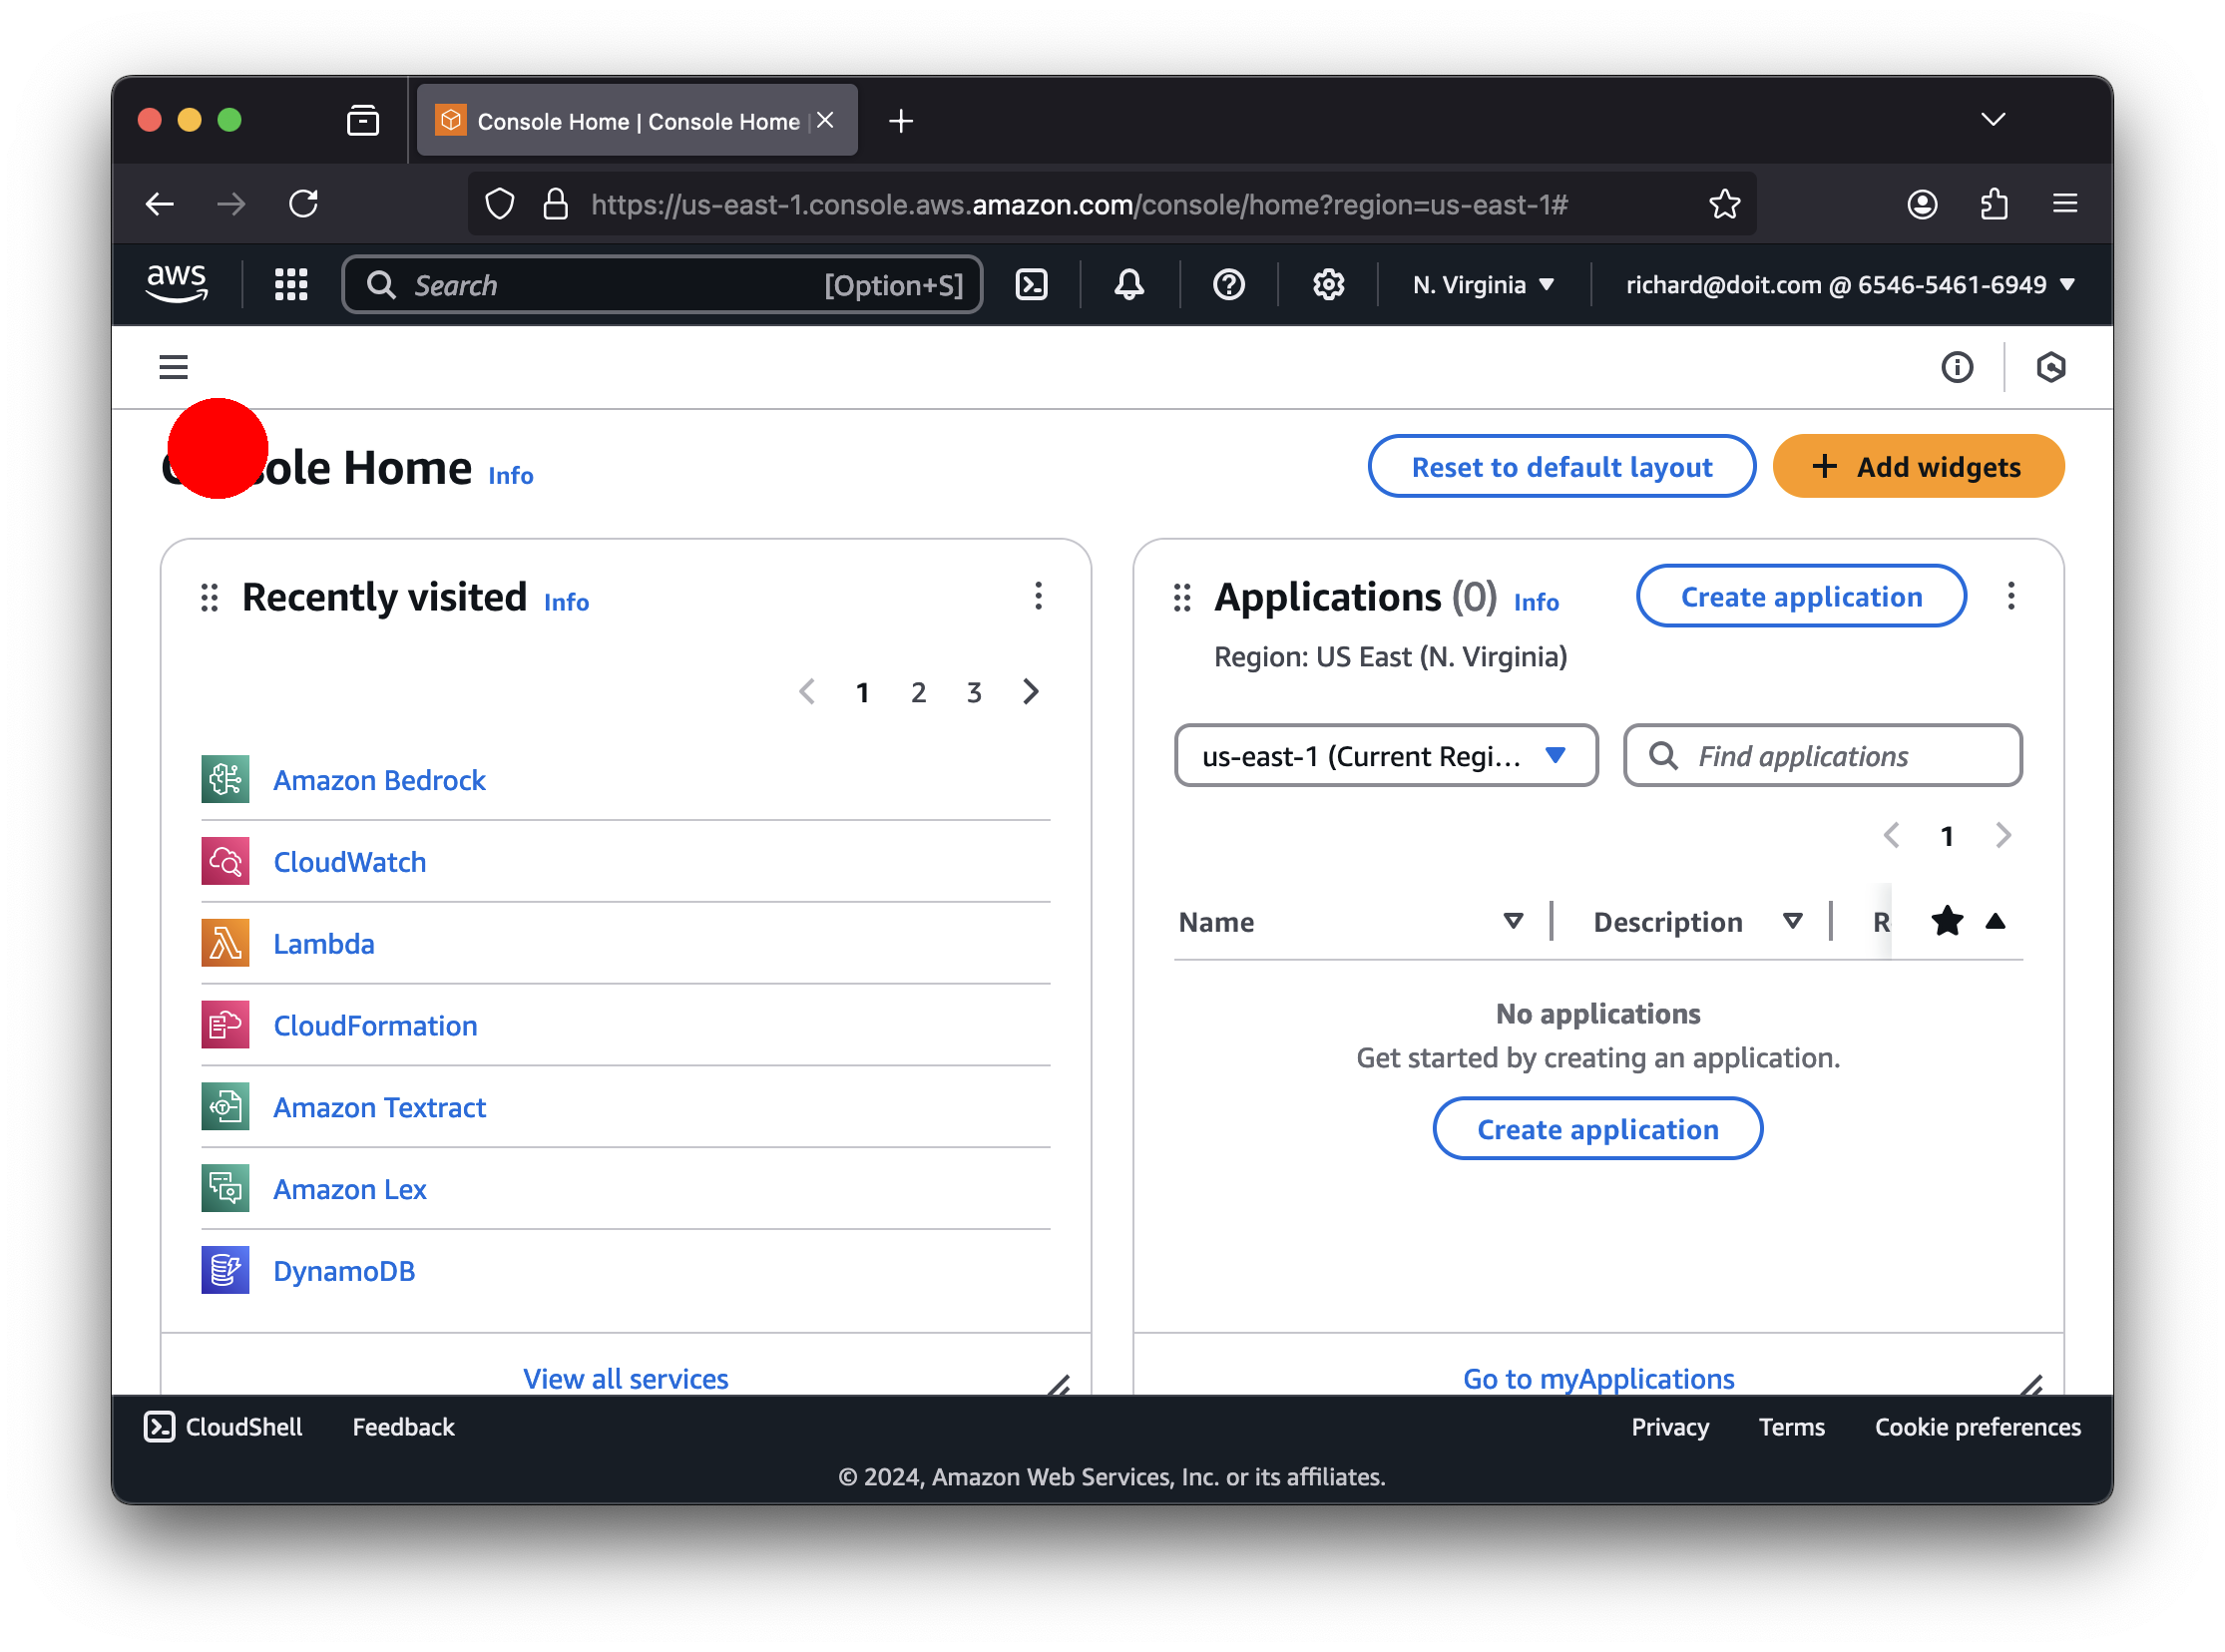

In [20]:
user_toolResult7=handle_action(agent_action7,
    input_screenshot='test_images/5-firefox_aws_console.png',
    output_screenshot='test_images/5-firefox_aws_console.png'
)

## 8th request

In [21]:
# user_toolResult5=handle_action(agent_action5,
#     input_screenshot='test_images/4-firefox_address_bar_text_enter.png',
#     output_screenshot='test_images/4-firefox_address_bar_text_enter.png'
# )

message8 = message7 + [{
        'role':'assistant',
        'content': agent_action7['output']['message']['content']
    },
    {
        'role':'user',
        'content': user_toolResult7
    }
]
agent_action8=send_bedrock(message6)
pprint.pprint(agent_action8)

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '531',
                                      'content-type': 'application/json',
                                      'date': 'Mon, 23 Dec 2024 13:40:23 GMT',
                                      'x-amzn-requestid': '1e97acd8-2dbe-4b84-9025-509da7d559dc'},
                      'HTTPStatusCode': 200,
                      'RequestId': '1e97acd8-2dbe-4b84-9025-509da7d559dc',
                      'RetryAttempts': 1},
 'metrics': {'latencyMs': 5749},
 'output': {'message': {'content': [{'text': "I'll help you enter your email "
                                             'address and proceed with the '
                                             'sign-in process.\n'
                                             '\n'
                                             "1. First, I notice we're on the "
                                             'Root user sign-in option,

[2024-12-23 21:40:33,738] p11073 {287690401.py:39} INFO - coordinate: [306, 779]


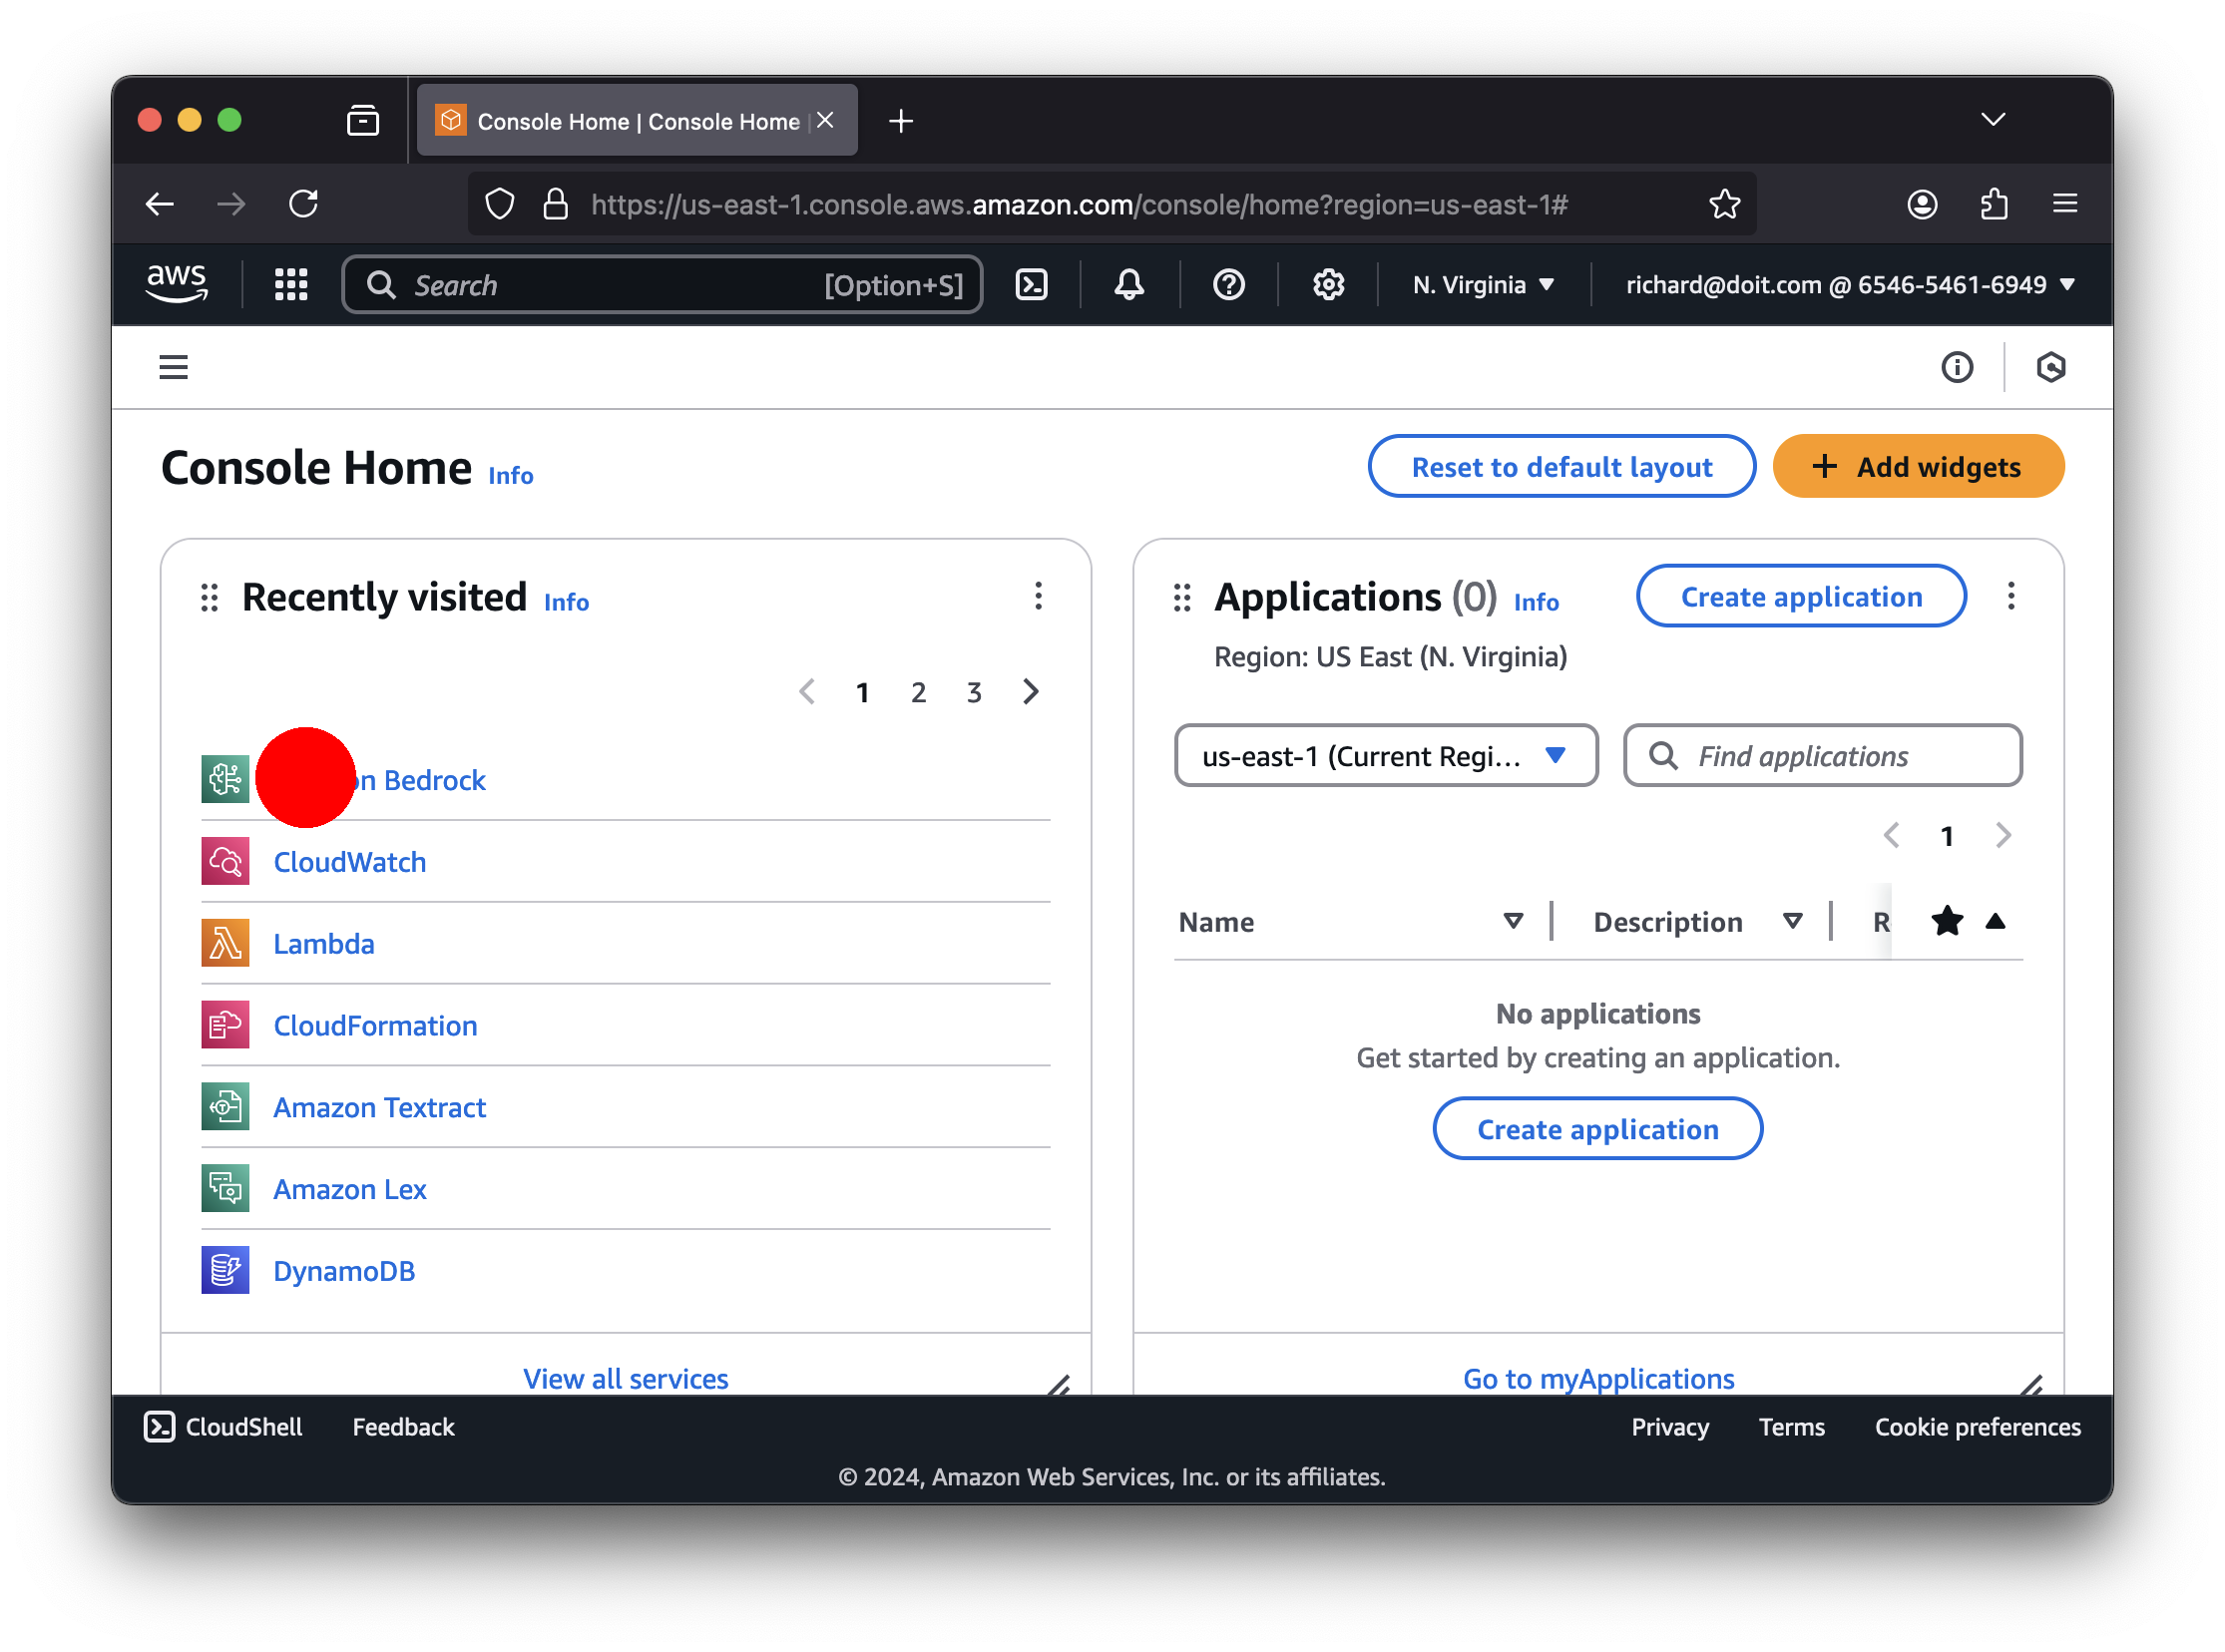

In [22]:
user_toolResult8=handle_action(agent_action8,
    input_screenshot='test_images/5-firefox_aws_console.png',
    output_screenshot='test_images/6-firefox_aws_bedrock_console.png'
)

## 9th Request

In [23]:
# user_toolResult5=handle_action(agent_action5,
#     input_screenshot='test_images/4-firefox_address_bar_text_enter.png',
#     output_screenshot='test_images/4-firefox_address_bar_text_enter.png'
# )

message9 = message8 + [{
        'role':'assistant',
        'content': agent_action8['output']['message']['content']
    },
    {
        'role':'user',
        'content': user_toolResult8
    }
]
agent_action9=send_bedrock(message9)
pprint.pprint(agent_action9)

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '710',
                                      'content-type': 'application/json',
                                      'date': 'Mon, 23 Dec 2024 13:41:41 GMT',
                                      'x-amzn-requestid': '7d2aec32-5414-4e1a-b723-6a52e0d44493'},
                      'HTTPStatusCode': 200,
                      'RequestId': '7d2aec32-5414-4e1a-b723-6a52e0d44493',
                      'RetryAttempts': 7},
 'metrics': {'latencyMs': 8442},
 'output': {'message': {'content': [{'text': "Great! I see we've successfully "
                                             'navigated to the Amazon Bedrock '
                                             "console. You're now on the main "
                                             'Bedrock overview page where you '
                                             'can:\n'
                                             '\n'

In [24]:
user_toolResult9=handle_action(agent_action9)
pprint.pprint(user_toolResult9)


In [ ]:
agent_action9['stopReason']